<a href="https://colab.research.google.com/github/paris3169/ZM-study-practice/blob/main/Backtester2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Complete Backterster Class Example

In [ ]:
import tpqoa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
plt.style.use("seaborn")
%matplotlib inline

In [ ]:
path=r"C:\Users\epardet\OneDrive - Ericsson AB\area lavoro\actual desktop\mytraining 2021\Python and data science\Udemy Courses\Algorithmic Trading A to Z\Part3_Materials\Part3_Materials\my practices"

In [ ]:
api = tpqoa.tpqoa(path+"\oanda.cfg")

In [ ]:
class Backtester():
    ''' this is a Complete Strategy Backtester'''
    
    def __init__(self,symbol,start,end,timeframe="D",ptc=0,strategy="SMAcrossing",window=3,SMA=[12,26],Boll=[20,2]):
        
        '''Parameters
        *****************************************
        symbol=ticker symbol
        start=start date of backtesting interval
        end=end date of backtesting interval
        timeframe= sampling period of data i.e. "D" = daily (see OANDA commnad get_history)
        
        strategy = type of strategy
        contrarian
        momentum
        SMAcrossing
        mean_revert
        
        ptc=fixed percentage trade cost
        window is the smoothing window considered for Contrarian/Momentum strategy
        SMA is a tuple (SMA1,SMA2) and is used for SMA Crossing startegy
        Boll is a tuple (SMA,dev)  and is used for the Mean Reversion strategy based on Bolliger Bands crossings
        
        '''
                
        self.symbol=symbol
        self.start=start
        self.end=end
        self.timeframe=timeframe
        self.ptc=ptc
        self.strategy=strategy
        self.window=window
        self.SMA=SMA
        self.Boll=Boll
        self.start_hour=2
        self.stop_hour=12
        
        
        self.results=None
        #self.get_data()
        
            
    def __repr__(self):
        self.header="Backtester class: strategy:{}, symbol:{}, start:{}, end:{}, timeframe: {}, ptc: {}".format(self.strategy,self.symbol,self.start,self.end,self.timeframe,self.ptc)
        self.header=self.header+" start_hour: {}, stop_hours: {}".format(self.start_hour,self.stop_hour)
        if (self.strategy=="contrarian") or (self.strategy=="momentum"):
            self.strategy_info="smoothing window: {}".format(self.window)
        if self.strategy=="SMAcrossing":
            self.strategy_info="SMA short: {}, SMA long: {} ".format(self.SMA[0],self.SMA[1])
        if self.strategy=="mean_revert":
            self.strategy_info="Bollinger SMA: {}, no of std dev: {}".format(self.Boll[0],self.Boll[1])
        if self.strategy=="combined":
            self.strategy_info="combined SMA+Bollinger SMA_S:{} SMA_L:{}, SMA_boll:{}, no of std dev: {}".format(self.SMA[0],self.SMA[1],self.Boll[0],self.Boll[1])
        return "{}\n{}".format(self.header,self.strategy_info)
        
    
    def get_data(self):
        '''this method is retrieving historical data from OANDA broaker'''
        
        raw=api.get_history(instrument = self.symbol, start = self.start, end = self.end,
                granularity = self.timeframe, price = "B")
        raw=raw["c"].to_frame().dropna()
        raw.rename(columns={"c": "Bid"},inplace=True)
        raw2=api.get_history(instrument = self.symbol, start = self.start, end = self.end,
                granularity = self.timeframe, price = "A")
        
        raw["Ask"]=raw2["c"]
        raw["price"]=0.5*(raw["Bid"]+raw["Ask"])   #mid price is considered the price of asset
        
        raw["spread"]=raw["Ask"]-raw["Bid"]       #calculate the spread
        raw["price_change"]=raw["price"].diff().abs()
        raw["covered_cost"]=raw["price_change"]>raw["spread"]
        raw["NY_hours"]=raw.index.tz_convert("America/New_York").hour
        
        self.data=raw.copy()
        dump=pd.DataFrame(self.data.values,index=raw.index.tz_convert(None),columns=raw.columns)
        dump.to_excel("{}_data.xlsx".format(self.symbol))    #dump data on ezxcel file for realod
        
    def check_cost(self):
        self.data_byhours=self.data.groupby("NY_hours")[["spread","price_change","covered_cost"]].mean()
        self.data_byhours.plot(kind = "bar", figsize = (12, 8), fontsize = 13,subplots=True)
        plt.xlabel("NY Time", fontsize = 15)
        
       
    def prepare_data(self):
        
        '''this method is calculating relevant indicators and positions signals depending on selected strategy
        '''
        
        raw=self.data.copy()
        #calculate log returns
        raw["returns"]=np.log(raw["price"]/raw["price"].shift())
        
        #calculate all indicators
        raw["window"]=raw["price"].rolling(self.window).mean()
        raw["SMA_S"]=raw["price"].rolling(self.SMA[0]).mean()
        raw["SMA_L"]=raw["price"].rolling(self.SMA[1]).mean()
        raw["Boll"]=raw["price"].rolling(self.Boll[0]).mean()
        raw["BollUp"]=raw["Boll"]+self.Boll[1]*raw["price"].rolling(self.Boll[0]).std()
        raw["BollLo"]=raw["Boll"]-self.Boll[1]*raw["price"].rolling(self.Boll[0]).std()
        raw["distance"]=raw["price"]-raw["Boll"]
        
        if self.strategy=="contrarian":
            #raw["window"]=raw["price"].rolling(self.window).mean()
            raw["position"]=-np.where(raw["price"]>raw["window"],1,-1) 
        elif self.strategy=="momentum":
            #raw["window"]=raw["price"].rolling(self.window).mean()
            raw["position"]=np.where(raw["price"]>raw["window"],1,-1)
        elif self.strategy=="SMAcrossing":
            #raw["SMA_S"]=raw["price"].rolling(self.SMA[0]).mean()
            #raw["SMA_L"]=raw["price"].rolling(self.SMA[1]).mean()
            raw["position"]=np.where(raw["SMA_S"]>raw["SMA_L"],1,-1)
        elif self.strategy=="mean_revert":
            #raw["Boll"]=raw["price"].rolling(self.Boll[0]).mean()
            #raw["BollUp"]=raw["Boll"]+self.Boll[1]*raw["price"].rolling(self.Boll[0]).std()
            #raw["BollLo"]=raw["Boll"]-self.Boll[1]*raw["price"].rolling(self.Boll[0]).std()
            #raw["distance"]=raw["price"]-raw["Boll"]
            #go Long if price is below Lower BBand or put nan in position
            raw["position"]=np.where(raw["price"]<raw["BollLo"],1,np.nan) 
            #go Short if price is above Upper BBand or keep existing position
            raw["position"]=np.where(raw["price"]>raw["BollUp"],-1,raw["position"])   
            #go Neutral in case the price is crossing the SMA level or keep existing position
            raw["position"]=np.where(raw["distance"]*raw["distance"].shift()<0,0,raw["position"])
            #remove residual nan positions using forward fill and set to 0=Neutral the first position
            raw["position"]=raw["position"].ffill().fillna(0)
        elif self.strategy=="combined":
            raw["position_SMA"]=np.where(raw["SMA_S"]>raw["SMA_L"],1,-1)
            raw["position_Boll"]=np.where(raw["price"]<raw["BollLo"],1,np.nan) 
            raw["position_Boll"]=np.where(raw["price"]>raw["BollUp"],-1,raw["position_Boll"])   
            raw["position_Boll"]=np.where(raw["distance"]*raw["distance"].shift()<0,0,raw["position_Boll"])
            raw["position_Boll"]=raw["position_Boll"].ffill().fillna(0)
            
            raw["position"]=np.sign(raw["position_SMA"]+raw["position_Boll"])
        
        #add here code for additional strategies
        
        #take into account onoy high trading hours       
        raw["position"]=np.where(raw["NY_hours"].between(self.start_hour,self.stop_hour),raw["position"],0)
        
        self.data=raw.dropna()
    
    
    def set_parameters(self,symbol=None,strategy=None,ptc=None,timeframe=None,start_hour=None,stop_hour=None):
        
        '''this method changes some relevant class attributes like symbol,and percentage trade cost
        if symbol is changed then also get_data and prepare_data methods are called to update instrument data'''
        
        if symbol is not None:
            self.symbol=symbol
            self.get_data()
        if strategy is not None:
            self.strategy=strategy
            self.prepare_data()
        if ptc is not None:
            self.ptc=ptc
        if timeframe is not None:
            #resampling S=seconds, H=hours, B=Business day, W=week, M=Month, Xmin=minuts
            
            self.data=self.data.resample(timeframe).last()
            self.timeframe=timeframe
            self.prepare_data()
        if (start_hour or stop_hour) is not None:
            if start_hour is not None:
                self.start_hour=start_hour
            if stop_hour is not None:
                self.stop_hour=stop_hour
            self.prepare_data()
    
    def test_strategy(self):
        
        '''this method is running the strategy testing'''
        
        data=self.data.copy().dropna()
        
        data["strategy"]=data["returns"]*data["position"].shift()
        data.dropna(inplace=True)

        #this is the way to calculate the number of trades 
        data["trades"]=data["position"].diff().fillna(0).abs()
               
        data["strategy_net"]=data["strategy"]-self.ptc*data["trades"]
        
        data["creturns"]=data["returns"].cumsum().apply(np.exp)
        data["cstrategy"]=data["strategy"].cumsum().apply(np.exp)
        data["cstrategy_net"]=data["strategy_net"].cumsum().apply(np.exp)
        
        self.results=data.dropna()
        
        gross_perf=data["cstrategy"].iloc[-1]
        net_perf=data["cstrategy_net"].iloc[-1]
        ref_perf=data["creturns"].iloc[-1]
        perf=pd.DataFrame(np.array([gross_perf,net_perf,ref_perf]),index=["cstrategy","cstrategy_net","buy&hold"],columns=["perf"])
        

        return np.round(perf,6)
    
    
    def split_data(self,split_ratio):
        #split ratio is the percentage of data to split for validation
        
        start_date_ind=int(len(self.data)*(1-split_ratio))
        start_date=self.data.index[start_date_ind]
        split_data=self.data.loc[start_date:]
        
        dump=pd.DataFrame(split_data.values,index=split_data.index,
                                     columns=split_data.columns)
        dump.to_excel("{}_split_data.xlsx".format(self.symbol))    #dump data on ezxcel file for realod
    
     
    def reload_data(self,kind=None):
        ''' this module allow reloading of data saved on a file. kind="split" then data are loaded from split file'''
        if kind=="split":
            identifier="split_"
        else:
            identifier=""
        self.data=pd.read_excel("{}_{}data.xlsx".format(self.symbol,identifier),index_col=0)
        print("data reloaded from file: {}_{}data.xlsx".format(self.symbol,identifier))
    
    
    def maxDrawDown(self,window=None):
        '''this module is calculating the max DrawDown of a strategy'''
        if window is not None:
            self.results["cummax"]=self.results["strategy"].rolling(window).max()
            self.results["DrawDown"]=self.results["cummax"]-self.results["strategy"]
            self.maxDD=self.results.iloc[np.argmax(self.results["DrawDown"]),:][-1:]
            return self.maxDD
        
    def Risk_calculator(self):
        '''this module is calculating the annualized Risk adjusted returns of the strategy'''
        strat_ann_ret=self.results["strategy"].mean()*252
        ann_ret_bench=self.results["returns"].mean()*252
        strat_ann_vol=self.results["strategy"].std()*np.sqrt(252)
        Sharpe = (strat_ann_ret-ann_ret_bench)/strat_ann_vol
        print("strategy_ann_ret: ",np.round(strat_ann_ret,5))
        print("strategy_ann_risk: ",np.round(strat_ann_vol,5))
        print("Strategy Sharpe ratio: ",np.round(Sharpe,5))
        return strat_ann_ret,strat_ann_vol,Sharpe
    
        
    def plot_results(self):
        '''this method is plotting the result of test_strategy'''
        
        if self.results is None:
            print("run test_strategy first")
        else:
            title=self.header+" "+self.strategy_info
            self.results[["creturns","cstrategy","cstrategy_net"]].plot(figsize=(16,8),title=title)
            print(self.results["trades"].value_counts())
            
    
    def optimize_strategy(self,windows=None,SMA_S_range=None,SMA_L_range=None,SMA_Boll_range=None,std_range=None):
        
        ''' this method is running a strategy parameter optimization
        NOT valid for AI based strategies'''
        
        many_results=[]
        df_perf=pd.DataFrame()   
        if windows is not None:
            #optimization for contrarian/momentum strategy parameters
            for window in windows:
                self.data["window"]=self.data["price"].rolling(window).mean()
                self.prepare_data()
                many_results.append(self.test_strategy().loc["cstrategy_net"][-1])
            best_perf=np.max(many_results)
            best_param=windows[np.argmax(many_results)]
            
            df_perf["window"]=windows
            df_perf["cstrategy"]=many_results
            self.df_perf=df_perf
            return best_perf,best_param
        
        if  (SMA_S_range and SMA_L_range) is not None:
            #optimization of SMAcrossing strategy parameters
            combinations=list(product(range(*SMA_S_range),range(*SMA_L_range)))
            for comb in combinations:
                self.SMA[0]=comb[0]
                self.SMA[1]=comb[1]
                self.prepare_data()
                many_results.append(self.test_strategy().loc["cstrategy_net"][-1])
            best_perf=np.max(many_results)
            best_param=combinations[np.argmax(many_results)]
            
            df_perf["comb"]=combinations
            df_perf["cstrategy"]=many_results
            self.df_perf=df_perf
            return best_perf,best_param
            
        if (SMA_Boll_range and std_range) is not None:
            #optimization of mean_revert strategy parameters
            combinations=list(product(range(*SMA_Boll_range),range(*std_range)))
            for comb in combinations:
                self.Boll[0]=comb[0]
                self.Boll[1]=comb[1]
                self.prepare_data()
                many_results.append(self.test_strategy().loc["cstrategy_net"][-1])
            best_perf=np.max(many_results)
            best_param=combinations[np.argmax(many_results)]
            
            df_perf["comb"]=combinations
            df_perf["cstrategy"]=many_results
            self.df_perf=df_perf
            return best_perf,best_param
        
        #add here code for additional strategies
         

In [ ]:
myBB=Backtester("EUR_USD","2021-06-01","2021-12-31",strategy="contrarian",timeframe="M15",ptc=0,SMA=[12,26],Boll=[20,3])

In [ ]:
myBB

Backtester class: strategy:contrarian, symbol:EUR_USD, start:2021-06-01, end:2021-12-31, timeframe: M15, ptc: 0 start_hour: 2, stop_hours: 12
smoothing window: 3

In [ ]:
myBB.get_data()

In [ ]:
myBB.reload_data()

data reloaded from file: EUR_USD_data.xlsx


In [ ]:
myBB.data

,Bid,Ask,price,spread,price_change,covered_cost,NY_hours
time,,,,,,,
2021-06-01 00:00:00,1.22254,1.22268,1.222610,0.00014,NaN,False,20
2021-06-01 00:15:00,1.22259,1.22273,1.222660,0.00014,0.000050,False,20
2021-06-01 00:30:00,1.22269,1.22284,1.222765,0.00015,0.000105,False,20
2021-06-01 00:45:00,1.22289,1.22304,1.222965,0.00015,0.000200,True,20
2021-06-01 01:00:00,1.22317,1.22331,1.223240,0.00014,0.000275,True,21
...,...,...,...,...,...,...,...
2021-12-30 22:45:00,1.13218,1.13243,1.132305,0.00025,0.000185,False,17
2021-12-30 23:00:00,1.13240,1.13258,1.132490,0.00018,0.000185,True,18
2021-12-30 23:15:00,1.13240,1.13256,1.132480,0.00016,0.000010,False,18


In [ ]:
myBB.data.tail()

,Bid,Ask,price,spread,price_change,covered_cost,NY_hours
time,,,,,,,
2021-12-30 22:45:00,1.13218,1.13243,1.132305,0.00025,0.000185,False,17
2021-12-30 23:00:00,1.13240,1.13258,1.132490,0.00018,0.000185,True,18
2021-12-30 23:15:00,1.13240,1.13256,1.132480,0.00016,0.000010,False,18
2021-12-30 23:30:00,1.13190,1.13204,1.131970,0.00014,0.000510,True,18
2021-12-30 23:45:00,1.13216,1.13231,1.132235,0.00015,0.000265,True,18


In [ ]:
myBB.split_data(0.3)

In [ ]:
myBB.data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4402 entries, 2021-10-28 00:30:00 to 2021-12-30 23:45:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Bid           4402 non-null   float64
 1   Ask           4402 non-null   float64
 2   price         4402 non-null   float64
 3   spread        4402 non-null   float64
 4   price_change  4402 non-null   float64
 5   covered_cost  4402 non-null   bool   
 6   NY_hours      4402 non-null   int64  
dtypes: bool(1), float64(5), int64(1)
memory usage: 245.0 KB


In [ ]:
myBB.reload_data(kind="split")

data reloaded from file: EUR_USD_split_data.xlsx


In [ ]:
myBB.data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14671 entries, 2021-06-01 00:00:00 to 2021-12-30 23:45:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Bid           14671 non-null  float64
 1   Ask           14671 non-null  float64
 2   price         14671 non-null  float64
 3   spread        14671 non-null  float64
 4   price_change  14670 non-null  float64
 5   covered_cost  14671 non-null  bool   
 6   NY_hours      14671 non-null  int64  
dtypes: bool(1), float64(5), int64(1)
memory usage: 1.3 MB


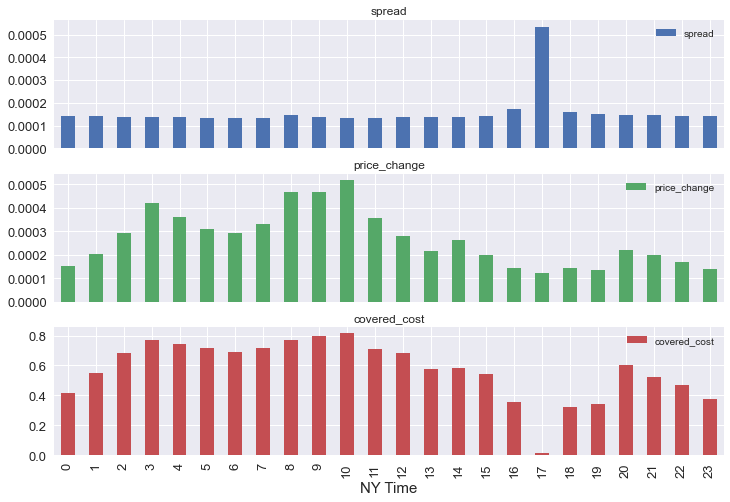

In [ ]:
myBB.check_cost()

In [ ]:
myBB.set_parameters(ptc=0.00015,start_hour=7,stop_hour=10)

In [ ]:
myBB

Backtester class: strategy:contrarian, symbol:EUR_USD, start:2021-06-01, end:2021-12-31, timeframe: M15, ptc: 0.00015 start_hour: 7, stop_hours: 10
smoothing window: 3

In [ ]:
myBB.set_parameters(timeframe="120min")

In [ ]:
myBB.data.tail()

,Bid,Ask,price,spread,price_change,covered_cost,NY_hours,returns,window,SMA_S,SMA_L,Boll,BollUp,BollLo,distance,position
time,,,,,,,,,,,,,,,,
2021-12-30 14:00:00,1.13300,1.13313,1.133065,0.00013,0.001380,1.0,10.0,0.002355,1.132022,1.133142,1.131879,1.132186,1.138666,1.125706,0.000879,-1
2021-12-30 16:00:00,1.13144,1.13158,1.131510,0.00014,0.000040,0.0,12.0,-0.001373,1.131658,1.132957,1.131855,1.132259,1.138583,1.125935,-0.000749,0
2021-12-30 18:00:00,1.13267,1.13280,1.132735,0.00013,0.001120,1.0,14.0,0.001082,1.132437,1.132827,1.131977,1.132364,1.138588,1.126141,0.000371,0
2021-12-30 20:00:00,1.13249,1.13267,1.132580,0.00018,0.000095,0.0,16.0,-0.000137,1.132275,1.132648,1.132036,1.132468,1.138553,1.126382,0.000112,0
2021-12-30 22:00:00,1.13216,1.13231,1.132235,0.00015,0.000265,1.0,18.0,-0.000305,1.132517,1.132336,1.132112,1.132579,1.138417,1.126741,-0.000344,0


In [ ]:
myBB.prepare_data()

In [ ]:
myBB.test_strategy()

,perf
cstrategy,1.01077
cstrategy_net,0.98917
buy&hold,0.97545


0.0    367
1.0    116
2.0     14
Name: trades, dtype: int64


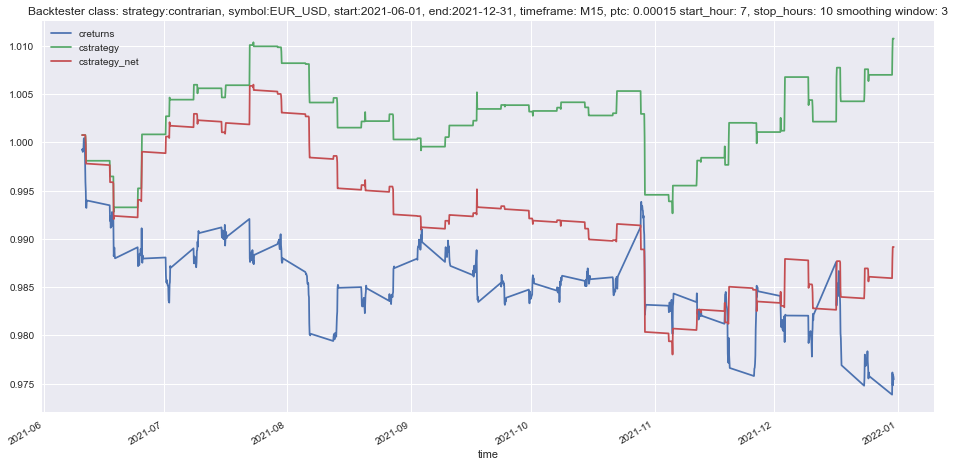

In [ ]:
myBB.plot_results()

In [ ]:
myBB.reload_data()

data reloaded from file: EUR_USD_data.xlsx


In [ ]:
myBB.set_parameters(strategy="momentum")

In [ ]:
myBB.data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2844 entries, 2021-06-04 03:00:00 to 2021-12-30 23:00:00
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Bid            2844 non-null   float64
 1   Ask            2844 non-null   float64
 2   price          2844 non-null   float64
 3   spread         2844 non-null   float64
 4   price_change   2844 non-null   float64
 5   covered_cost   2844 non-null   float64
 6   NY_hours       2844 non-null   float64
 7   returns        2844 non-null   float64
 8   window         2844 non-null   float64
 9   SMA_S          2844 non-null   float64
 10  SMA_L          2844 non-null   float64
 11  Boll           2844 non-null   float64
 12  BollUp         2844 non-null   float64
 13  BollLo         2844 non-null   float64
 14  distance       2844 non-null   float64
 15  position_SMA   2844 non-null   int32  
 16  position_Boll  2844 non-null   float64
 17  position       2

In [ ]:
myBB

Backtester class: strategy:momentum, symbol:EUR_USD, start:2021-06-01, end:2021-12-31, timeframe: 60min, ptc:0.00015start_hour: 7, stop_hours: 10
smoothing window: 3

In [ ]:
myBB.prepare_data()

In [ ]:
myBB.test_strategy()

,perf
cstrategy,0.97717
cstrategy_net,0.90548
buy&hold,0.92978


0.0    2445
1.0     238
2.0     135
Name: trades, dtype: int64


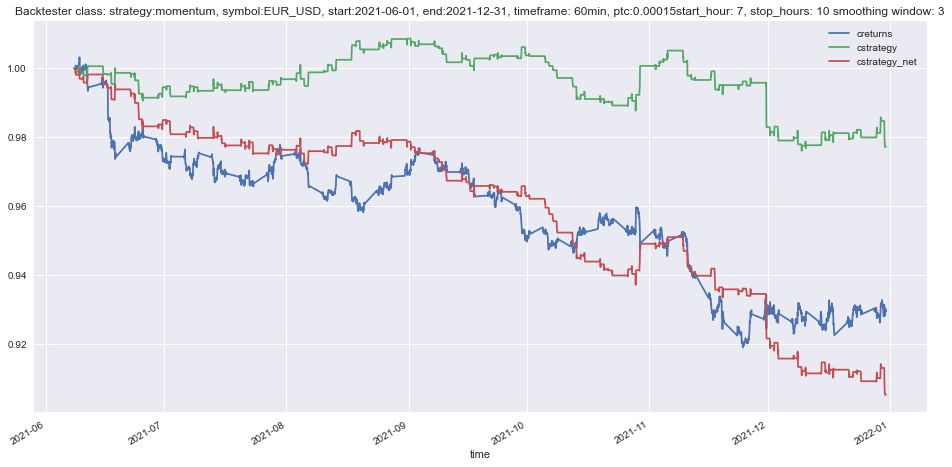

In [ ]:
myBB.plot_results()

In [ ]:
myBB.maxDrawDown(window=20)

DrawDown    0.011121
Name: 2021-11-30 15:30:00+00:00, dtype: float64

In [ ]:
myBB.Risk_calculator()

strategy_ann_ret:  0.00044
strategy_ann_risk:  0.00468
Strategy Sharpe ratio:  0.43722


(0.0004440876412429616, 0.00467514019126193, 0.4372244740541322)

In [ ]:
myBB.results

,time,Bid,Ask,price,spread,price_change,covered_cost,NY_hours,returns,window,...,distance,position_SMA,position_Boll,position,strategy,trades,strategy_net,creturns,cstrategy,cstrategy_net
51,2021-06-02 01:30:00,1.22208,1.22222,1.222150,0.00014,0.000305,True,21,-0.000250,1.222213,...,-0.000046,-1,0.0,0.0,-0.0,0.0,-0.0,0.999751,1.000000,1.000000
52,2021-06-02 02:00:00,1.22239,1.22252,1.222455,0.00013,0.000305,True,22,0.000250,1.222353,...,0.000313,-1,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000
53,2021-06-02 02:30:00,1.22229,1.22244,1.222365,0.00015,0.000090,False,22,-0.000074,1.222323,...,0.000268,-1,0.0,0.0,-0.0,0.0,-0.0,0.999926,1.000000,1.000000
54,2021-06-02 03:00:00,1.22219,1.22233,1.222260,0.00014,0.000105,False,23,-0.000086,1.222360,...,0.000195,-1,0.0,0.0,-0.0,0.0,-0.0,0.999840,1.000000,1.000000
55,2021-06-02 03:30:00,1.22224,1.22238,1.222310,0.00014,0.000050,False,23,0.000041,1.222312,...,0.000281,-1,0.0,0.0,0.0,0.0,0.0,0.999881,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7333,2021-12-30 21:30:00,1.13249,1.13267,1.132580,0.00018,0.000130,False,16,-0.000115,1.132407,...,0.000390,-1,0.0,0.0,-0.0,0.0,-0.0,0.926480,0.929275,0.862905
7334,2021-12-30 22:00:00,1.13198,1.13283,1.132405,0.00085,0.000175,False,17,-0.000155,1.132565,...,0.000232,-1,0.0,0.0,-0.0,0.0,-0.0,0.926337,0.929275,0.862905
7335,2021-12-30 22:30:00,1.13218,1.13243,1.132305,0.00025,0.000100,False,17,-0.000088,1.132430,...,0.000233,-1,0.0,0.0,-0.0,0.0,-0.0,0.926255,0.929275,0.862905
7336,2021-12-30 23:00:00,1.13240,1.13256,1.132480,0.00016,0.000175,True,18,0.000155,1.132397,...,0.000461,-1,0.0,0.0,0.0,0.0,0.0,0.926398,0.929275,0.862905


In [ ]:
df=myBB.results.returns.to_frame()

In [ ]:
df

,returns
time,
2021-06-03 03:00:00,0.000201
2021-06-03 04:00:00,-0.000414
2021-06-03 05:00:00,-0.000418
2021-06-03 06:00:00,-0.000812
2021-06-03 07:00:00,-0.000451
...,...
2021-12-30 19:00:00,0.001891
2021-12-30 20:00:00,-0.000711
2021-12-30 21:00:00,0.000574


In [ ]:
len(myBB.data)

498

In [ ]:
start_date_ind=int(len(myBB.data)*(1-0.3))

In [ ]:
start_date_ind

348

In [ ]:
start_date=myBB.data.index[start_date_ind]

In [ ]:
start_date

Timestamp('2021-10-29 04:00:00')

In [ ]:
myBB.data.loc[start_date:]

,Bid,Ask,price,spread,price_change,covered_cost,NY_hours,returns,window,SMA_S,SMA_L,Boll,BollUp,BollLo,distance,position
time,,,,,,,,,,,,,,,,
2021-10-29 04:00:00,1.16670,1.16684,1.166770,0.00014,0.000355,1.0,1.0,-0.000758,1.167390,1.165775,1.162839,1.163604,1.175282,1.151927,0.003166,0
2021-10-29 06:00:00,1.16696,1.16712,1.167040,0.00016,0.000105,0.0,3.0,0.000231,1.167155,1.166289,1.163104,1.163956,1.175561,1.152350,0.003084,0
2021-10-29 08:00:00,1.16526,1.16539,1.165325,0.00013,0.000245,1.0,5.0,-0.001471,1.166378,1.166793,1.163324,1.164145,1.175654,1.152637,0.001180,0
2021-10-29 10:00:00,1.16464,1.16478,1.164710,0.00014,0.000055,0.0,7.0,-0.000528,1.165692,1.167212,1.163484,1.164380,1.175515,1.153246,0.000330,1
2021-10-29 12:00:00,1.16186,1.16200,1.161930,0.00014,0.000930,1.0,9.0,-0.002390,1.163988,1.166900,1.163591,1.164464,1.175360,1.153567,-0.002534,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-30 14:00:00,1.13300,1.13313,1.133065,0.00013,0.001380,1.0,10.0,0.002355,1.132022,1.133142,1.131879,1.132186,1.138666,1.125706,0.000879,-1
2021-12-30 16:00:00,1.13144,1.13158,1.131510,0.00014,0.000040,0.0,12.0,-0.001373,1.131658,1.132957,1.131855,1.132259,1.138583,1.125935,-0.000749,0
2021-12-30 18:00:00,1.13267,1.13280,1.132735,0.00013,0.001120,1.0,14.0,0.001082,1.132437,1.132827,1.131977,1.132364,1.138588,1.126141,0.000371,0
